In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()


Saving dataset_ecommerce.csv to dataset_ecommerce (1).csv


In [23]:

# Cargo dataset
df = pd.read_csv("dataset_ecommerce.csv")



In [24]:
df

,id_cliente,fecha_compra,factura_id,cantidad,monto,segmento_cliente,pais,canal_compra
0,1,2023-01-21,1,8,4349.90,Medio,España,Tienda física
1,1,2023-03-13,2,5,4390.07,Medio,España,Tienda física
2,1,2023-04-17,3,3,2250.20,Medio,España,Online
3,1,2023-05-02,4,7,3806.86,Medio,España,Online
4,1,2023-09-28,5,6,3544.78,Medio,España,Online
...,...,...,...,...,...,...,...,...
14995,2527,2023-10-02,14996,2,1384.89,Medio,Italia,Tienda física
14996,2527,2023-11-19,14997,2,1001.64,Medio,Italia,Online
14997,2527,2023-12-25,14998,7,6003.78,Medio,Italia,Tienda física
14998,2527,2024-04-18,14999,7,4405.35,Medio,Italia,Tienda física


**LIMPIEZA**

---



In [25]:
#cambio el nombre
df.rename(columns={'fecha_compra':'fecha'},inplace=True)




In [26]:
#cambio  a formato fecha
df['fecha'] = pd.to_datetime(df['fecha'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_cliente        15000 non-null  int64         
 1   fecha             15000 non-null  datetime64[ns]
 2   factura_id        15000 non-null  int64         
 3   cantidad          15000 non-null  int64         
 4   monto             14718 non-null  float64       
 5   segmento_cliente  15000 non-null  object        
 6   pais              15000 non-null  object        
 7   canal_compra      15000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 937.6+ KB


In [28]:
df.isna().sum()

,0
id_cliente,0
fecha,0
factura_id,0
cantidad,0
monto,282
segmento_cliente,0
pais,0
canal_compra,0


In [29]:
#elimino valores nulos
df = df.dropna()

In [30]:
#elimino montos  <= a 0

df = df[df['monto'] > 0]


In [31]:
#Creo columna región (Reino Unido u Otros)
df['region'] = df['pais'].apply(lambda x: "Reino Unido" if x == "Reino Unido" else "Otros")

df.head()

,id_cliente,fecha,factura_id,cantidad,monto,segmento_cliente,pais,canal_compra,region
0,1,2023-01-21,1,8,4349.90,Medio,España,Tienda física,Otros
1,1,2023-03-13,2,5,4390.07,Medio,España,Tienda física,Otros
2,1,2023-04-17,3,3,2250.20,Medio,España,Online,Otros
3,1,2023-05-02,4,7,3806.86,Medio,España,Online,Otros
4,1,2023-09-28,5,6,3544.78,Medio,España,Online,Otros


In [32]:
#cuento  la cantidad de  clientes de reino unico y de otros
df['region'].value_counts()


,count
region,
Otros,11804
Reino Unido,2141


**ANALISIS COHORTE**

---



In [33]:
#creo la columna mes año
df['periodo'] = df['fecha'].dt.to_period('M')

In [34]:
# Cohorte: primer mes de compra del cliente

df['cohorte'] = df.groupby('id_cliente')['periodo'].transform('min')

In [35]:
# Convierto periodos a números (para calcular diferencia en meses)

df['periodo_num'] = df['periodo'].apply(lambda p: p.year * 12 + p.month)
df['cohorte_num'] = df['cohorte'].apply(lambda p: p.year  * 12 + p.month)

In [36]:
#Índice de cohorte (mes 1, mes 2, mes 3 desde la primer compra)
df['cohorte_index']= df['periodo_num'] - df['cohorte_num'] + 1

**Matriz de retencion de clientes en general**

---



In [37]:
# Agrupo por cohorte (mes de ingreso) y por cohorte_index (meses desde el ingreso)
# y cuento la cantidad de clientes únicos en cada combinación.
cohorte_general = (
    df.groupby(['cohorte', 'cohorte_index'])['id_cliente']
      .nunique()
      .reset_index()

  # Pivot para crear la tabla de cohortes
      .pivot(index='cohorte', columns='cohorte_index', values='id_cliente')
)


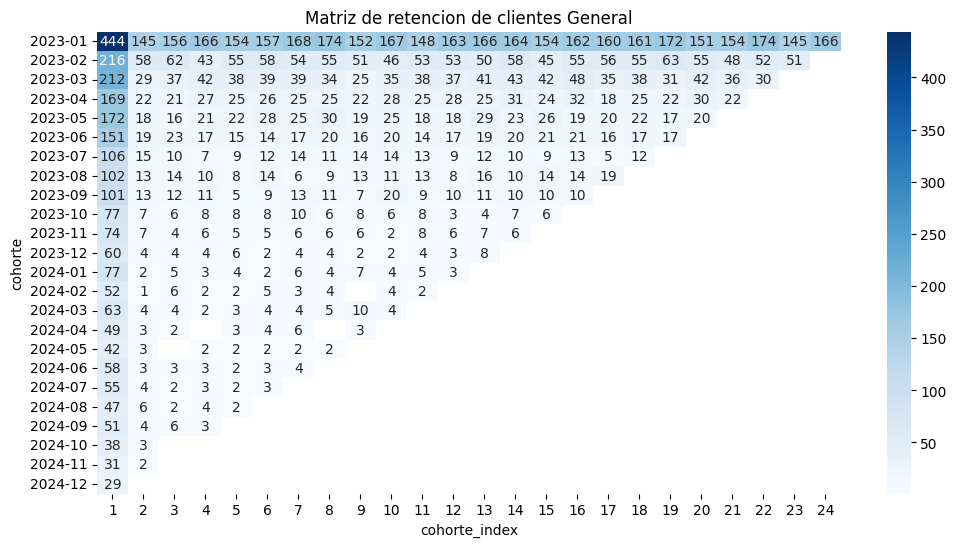

In [38]:
#Grafico

plt.figure(figsize=(12,6))
sns.heatmap(cohorte_general, annot=True, fmt='.0f', cmap='Blues')
plt.title('Matriz de retencion de clientes General')
plt.show()


**Matriz de retencion de clientes Reino Unido**

---



In [39]:
#filtro solo los clientes de Reino Unido
df_uk = df[df['region'] == 'Reino Unido']

# Agrupo por cohorte (mes de ingreso) y por cohorte_index (meses desde el ingreso)
# y cuento la cantidad de clientes únicos en cada combinación.
cohorte_uk = (
    df_uk.groupby(['cohorte', 'cohorte_index'])['id_cliente']
         .nunique()
         .reset_index()

# Pivot para crear la tabla de cohortes
         .pivot(index='cohorte', columns='cohorte_index', values='id_cliente')
)


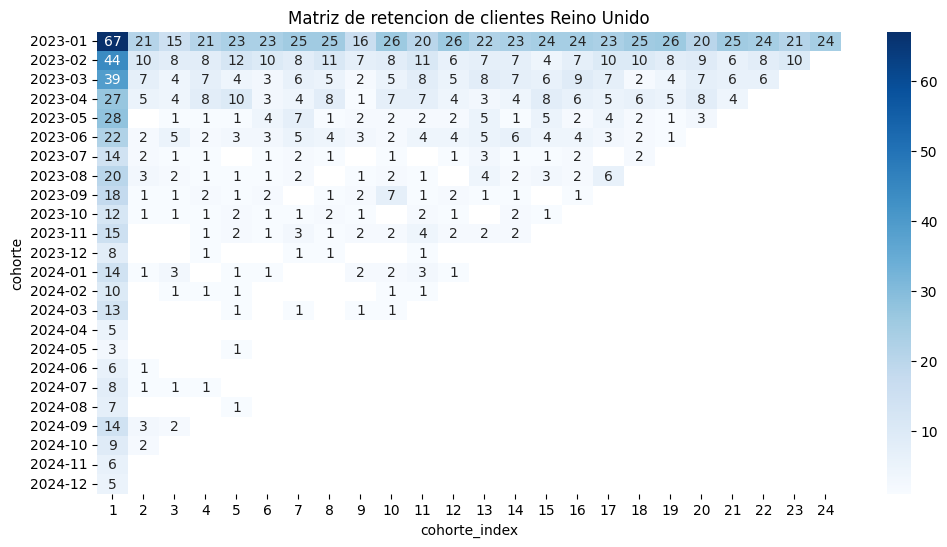

In [40]:
#Grafico


plt.figure(figsize=(12,6))
sns.heatmap(cohorte_uk, annot=True, fmt='.0f', cmap='Blues')
plt.title('Matriz de retencion de clientes Reino Unido')
plt.show()

**Matriz de retencion de clientes Otros paises**

---



In [41]:
#filtro solo los clientes otros
df_otros = df[df['region'] == 'Otros']

# Agrupo por cohorte (mes de ingreso) y por cohorte_index (meses desde el ingreso)
# y cuento la cantidad de clientes únicos en cada combinación.
cohorte_otros = (
    df_otros.groupby(['cohorte', 'cohorte_index'])['id_cliente']
            .nunique()
            .reset_index()

# Pivot para crear la tabla de cohortes
            .pivot(index='cohorte', columns='cohorte_index', values='id_cliente')
)


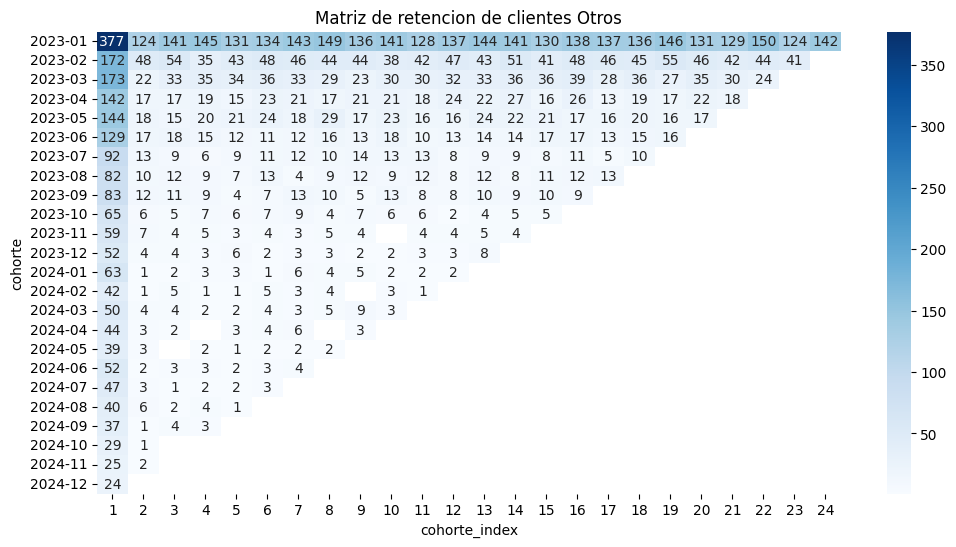

In [42]:
#Grafico


plt.figure(figsize=(12,6))
sns.heatmap(cohorte_otros, annot=True, fmt='.0f', cmap='Blues')
plt.title('Matriz de retencion de clientes Otros')
plt.show()
